In [232]:
import copy

import torch
import torch_geometric as pyg
import numpy as np
import  src.cgvae.data_transform
import importlib
importlib.reload(src.cgvae.data_transform)
from src.cgvae.data_transform import get_data
import src.cgvae.baseline
importlib.reload(src.cgvae.baseline)
import src.cgvae.cgvae_model
importlib.reload(src.cgvae.cgvae_model)

import  src.cgvae
importlib.reload(src.cgvae)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

torch.manual_seed(123)
np.random.seed(123)

<module 'src.cgvae.data_transform' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/src/cgvae/data_transform.py'>

<module 'src.cgvae.baseline' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/src/cgvae/baseline.py'>

<module 'src.cgvae.cgvae_model' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/src/cgvae/cgvae_model.py'>

<module 'src.cgvae' from '/Users/cgu3/Documents/conditional-graph-variational-autoencoder/src/cgvae/__init__.py'>

In [233]:
%cd /Users/cgu3/Documents/conditional-graph-variational-autoencoder
%pwd

/Users/cgu3/Documents/conditional-graph-variational-autoencoder


'/Users/cgu3/Documents/conditional-graph-variational-autoencoder'

In [273]:
SPLIT_RATIO = 0.5
# dataloader, dataset_size = get_data('../data', 'Cora', mask_ratio=SPLIT_RATIO, num_val=0.1, num_test=0.1, 
#                                     neg_edge_ratio=10)
dataloader, dataset_size = get_data('../data', 'KarateClub',  mask_ratio=SPLIT_RATIO, num_val=0.1, num_test=0,  
                                    neg_edge_ratio=5)

In [274]:
data = next(iter(dataloader))
dim = data['input'].x.shape[0]

In [275]:
baseline_net = src.cgvae.baseline.train(
    device='cpu',
    dataloader=dataloader,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.005,
    num_epochs=100,
    model_path='checkpoints/baseline_net.pth',
    early_stop_patience=10
)

NN Epoch 37         : 100%|██████████| 1/1 [00:00<00:00, 313.97it/s, early_stop_count=9, loss=0.6762, phase=val]


In [276]:
cgvae_net = src.cgvae.cgvae_model.train(
    device='cpu',
    dataloader=dataloader,
    num_node_features=data['input'].x.size(1),
    learning_rate=0.005,
    num_epochs=300,
    pre_trained_baseline_net=baseline_net,
    model_path='checkpoints/cgvae_net.pth',
    early_stop_patience=1000,
    regularization=1
)

CVAE Epoch 299      : 100%|██████████| 1/1 [00:00<00:00, 243.49it/s, early_stop_count=99, loss=0.7320, phase=val]


In [277]:
# generate missing part based on the trained model

In [278]:
# sample one data from the dataloader
graphs = next(iter(dataloader))
graphs

{'input': DataBatch(x=[34, 34], edge_index=[2, 96], edge_weight=[96], batch=[34], ptr=[2]),
 'output': DataBatch(x=[34, 34], edge_index=[2, 328], edge_label=[328], train_mask=[328], val_mask=[328], test_mask=[328], batch=[34], ptr=[2])}

In [279]:
graphs['output'].x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

# Visualize the input graph

Text(0.5, 1.0, 'Heatmap of 2D Tensor')

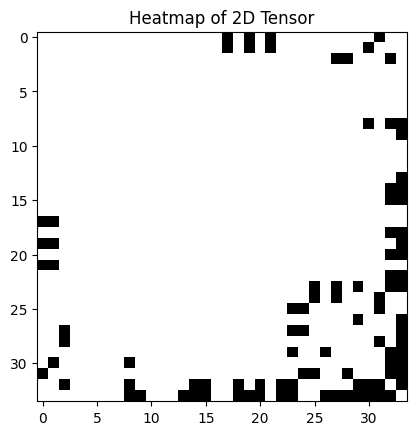

Text(0.5, 1.0, 'Heatmap of 2D Tensor')

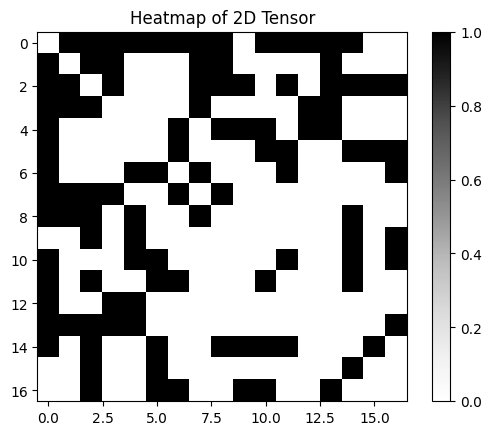

In [280]:
import matplotlib.pyplot as plt
split = int(dim * SPLIT_RATIO)
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index, 
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
# Plot the heatmap
plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
plt.title("Heatmap of 2D Tensor")
plt.show()
plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
plt.colorbar()  # Add a colorbar to a plot
plt.title("Heatmap of 2D Tensor")
plt.show()

In [281]:
# Convert the tensor to a NumPy array
# Plot the heatmap


In [282]:
# use the trained model to generate the missing part
baseline_net(graphs['input'])

tensor([[ 0.5540,  0.4358, -0.2152,  ..., -0.1184, -0.4086, -0.3455],
        [ 0.4358,  0.3504, -0.1562,  ..., -0.0843, -0.3036, -0.2495],
        [-0.2152, -0.1562,  0.1399,  ...,  0.0821,  0.2198,  0.2047],
        ...,
        [-0.1184, -0.0843,  0.0821,  ...,  0.0595,  0.1310,  0.1234],
        [-0.4086, -0.3036,  0.2198,  ...,  0.1310,  0.3837,  0.3488],
        [-0.3455, -0.2495,  0.2047,  ...,  0.1234,  0.3488,  0.3286]],
       grad_fn=<MmBackward0>)

In [283]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<Axes: >

Text(0.5, 1.0, 'Input')

<Axes: >

Text(0.5, 1.0, 'Output')

<Axes: >

Text(0.5, 1.0, 'Baseline model')

<Axes: >

Text(0.5, 1.0, 'Recognition model')

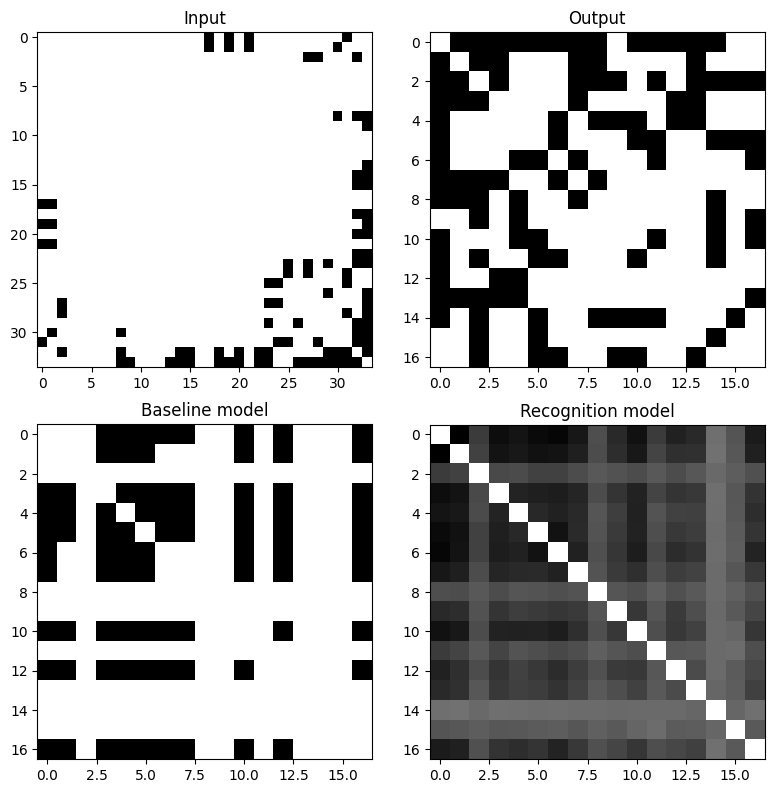

In [284]:
dim = graphs['input'].x.size(0)
adj_mat_inp = pyg.utils.to_dense_adj(graphs['input'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
adj_mat_out = pyg.utils.to_dense_adj(graphs['output'].edge_index,
                                     max_num_nodes=graphs['input'].x.size(0)).squeeze().numpy()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
threshold = 0.8


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplot(221)
plt.imshow(adj_mat_inp, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Input")

plt.subplot(222)
plt.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Output")

plt.subplot(223)
adj_mat_np = baseline_net.predict(graphs['input']).detach().numpy()[:split, :split]
# adj_mat_np[adj_mat_np < threshold] = 0
# adj_mat_np = np.random.binomial(1, adj_mat_np)
np.fill_diagonal(adj_mat_np, 0)
plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Baseline model")

plt.subplot(224)
adj_mat_np = np.zeros((split, split))
for i in range(100):
    adj_mat_np += sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
adj_mat_np /= 100
# adj_mat_np[adj_mat_np < threshold] = 0
# adj_mat_np[adj_mat_np >= threshold] = 1
np.fill_diagonal(adj_mat_np, 0)
plt.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
plt.title("Recognition model")

# also try unconditional generation


plt.show()



Text(0.5, 1.0, 'Output')

Text(0.5, 1.0, 'Recognition model generated graph (average)')

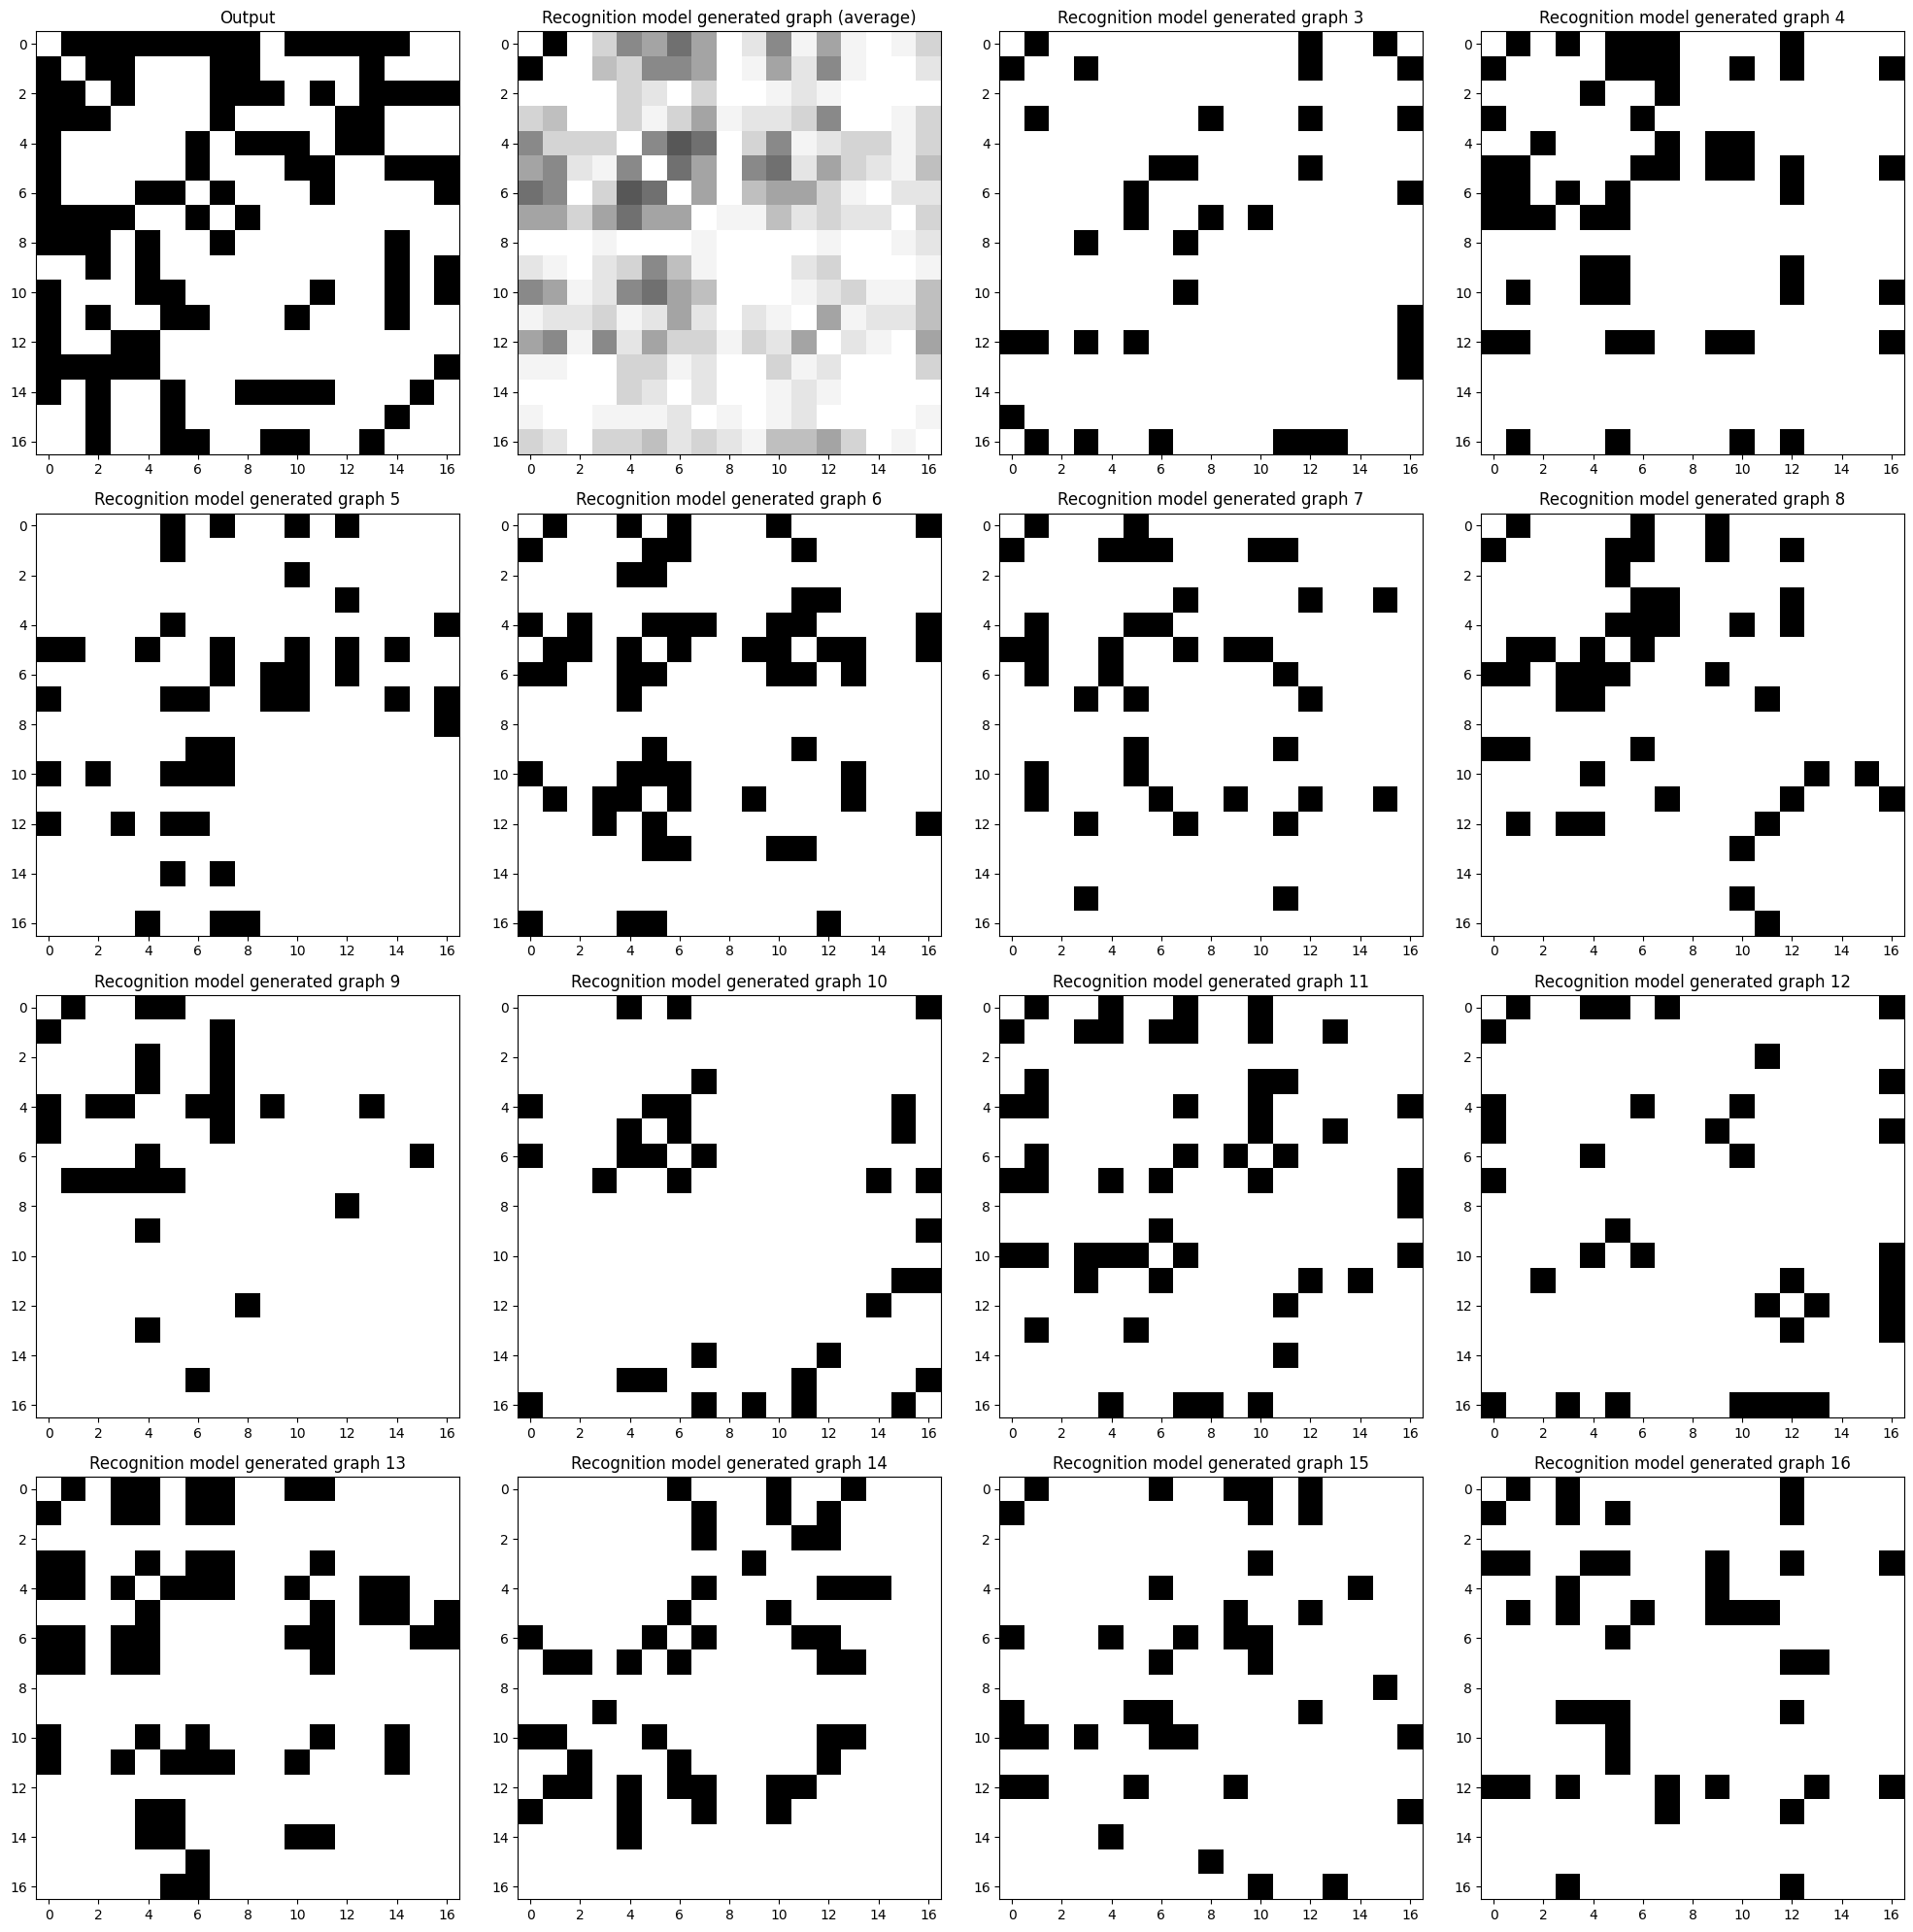

In [285]:
cgvae_net.load('checkpoints/cgvae_net.pth')
threshold = 0.7

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

avg_adj_mat_np = np.zeros((split, split))

for i in range(2, 16):
    adj_mat_np = sigmoid(cgvae_net.generate().detach().numpy())[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np[adj_mat_np >= threshold] = 1
    # adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    avg_adj_mat_np += adj_mat_np
    ax = axes[i]  # Select the i-th subplot
    _ = ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    _ = ax.set_title(f"Recognition model generated graph {i+1}")  # Set the title for the i-th subplot

avg_adj_mat_np /= 14

# avg_adj_mat_np[avg_adj_mat_np < 0.7] = 0
# avg_adj_mat_np[avg_adj_mat_np >= 0.7] = 1

ax = axes[1]
ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
ax.set_title("Recognition model generated graph (average)")

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

In [294]:
import imageio
import os
import copy

# Ensure the directory exists
os.makedirs('cgvae', exist_ok=True)

threshold_values = np.linspace(0.5, 1, 10)  # Change this to the range of threshold values you want to use
filenames = []

adj_mat_np_list = []
# generate 14 graphs
for i in range(14):
    adj_mat_np_list.append(sigmoid(cgvae_net.generate().detach().numpy())[:split, :split])

for t in threshold_values:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    axes = axes.flatten()

    ax = axes[0]
    _ = ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
    _ = ax.set_title("Output")

    avg_adj_mat_np = np.zeros((split, split))
    adj_mat_np_list_temp =copy.deepcopy(adj_mat_np_list)
    for adj_mat_np in adj_mat_np_list_temp:
        adj_mat_np[adj_mat_np < t] = 0
        adj_mat_np[adj_mat_np >= t] = 1
        np.fill_diagonal(adj_mat_np, 0)
        avg_adj_mat_np += adj_mat_np
    
    # avg_adj_mat_np[avg_adj_mat_np < threshold] = 0
    # avg_adj_mat_np[avg_adj_mat_np >= threshold] = 1
    # plot the average
    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')

    # plot the rest
    for i in range(2, 16):
        ax = axes[i]
        _ = ax.imshow(adj_mat_np_list_temp[i-2], cmap='Greys', interpolation='nearest')
        _ = ax.set_title(f"Recognition model generated graph {i}")

    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
    _= ax.set_title("Recognition model generated graph (average)")

    plt.tight_layout()

    # Save the figure to a file
    filename = f'cgvae/output_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)

    plt.close()  # Close the figure to free up memory

In [295]:
# from the images make a video
images = [imageio.imread(filename) for filename in filenames]
imageio.mimsave('cgvae/output2.gif', images, fps=1)

# remove the files
# for filename in filenames:
#     os.remove(filename)

/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_71254/3300650343.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


In [286]:
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.datasets import Planetoid, KarateClub
import torch_geometric.transforms as T
from datetime import time
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch_geometric.nn import VGAE
# Unconditional generation
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class VGAEWithGenerate(VGAE):
    def __init__(self, encoder):
        super().__init__(encoder)
        self.encoder = encoder
        
    def generate(self):
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return self.decoder.forward_all(z)

vgae_model = VGAEWithGenerate(VariationalGCNEncoder(34, 34*2))
model = vgae_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


# train_data = Planetoid(root='../data', name='Cora', pre_transform=ToUndirected())[0]
# use karate club data
train_data =  dataset = KarateClub()
train_data.pos_edge_label_index = train_data.edge_index
train_data.neg_edge_label_index = pyg.utils.negative_sampling(
    train_data.edge_index, num_nodes=34)

# train the model
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    loss = loss + (1 / 34) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

times = []
for epoch in range(1, 100 + 1):
    # start = time.time()
    loss = train()
    # auc, ap = test(test_data)
    # print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    # times.append(time.time() - start)
# print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

In [287]:
split

17

Text(0.5, 1.0, 'Output')

Text(0.5, 1.0, 'Recognition model generated graph (average)')

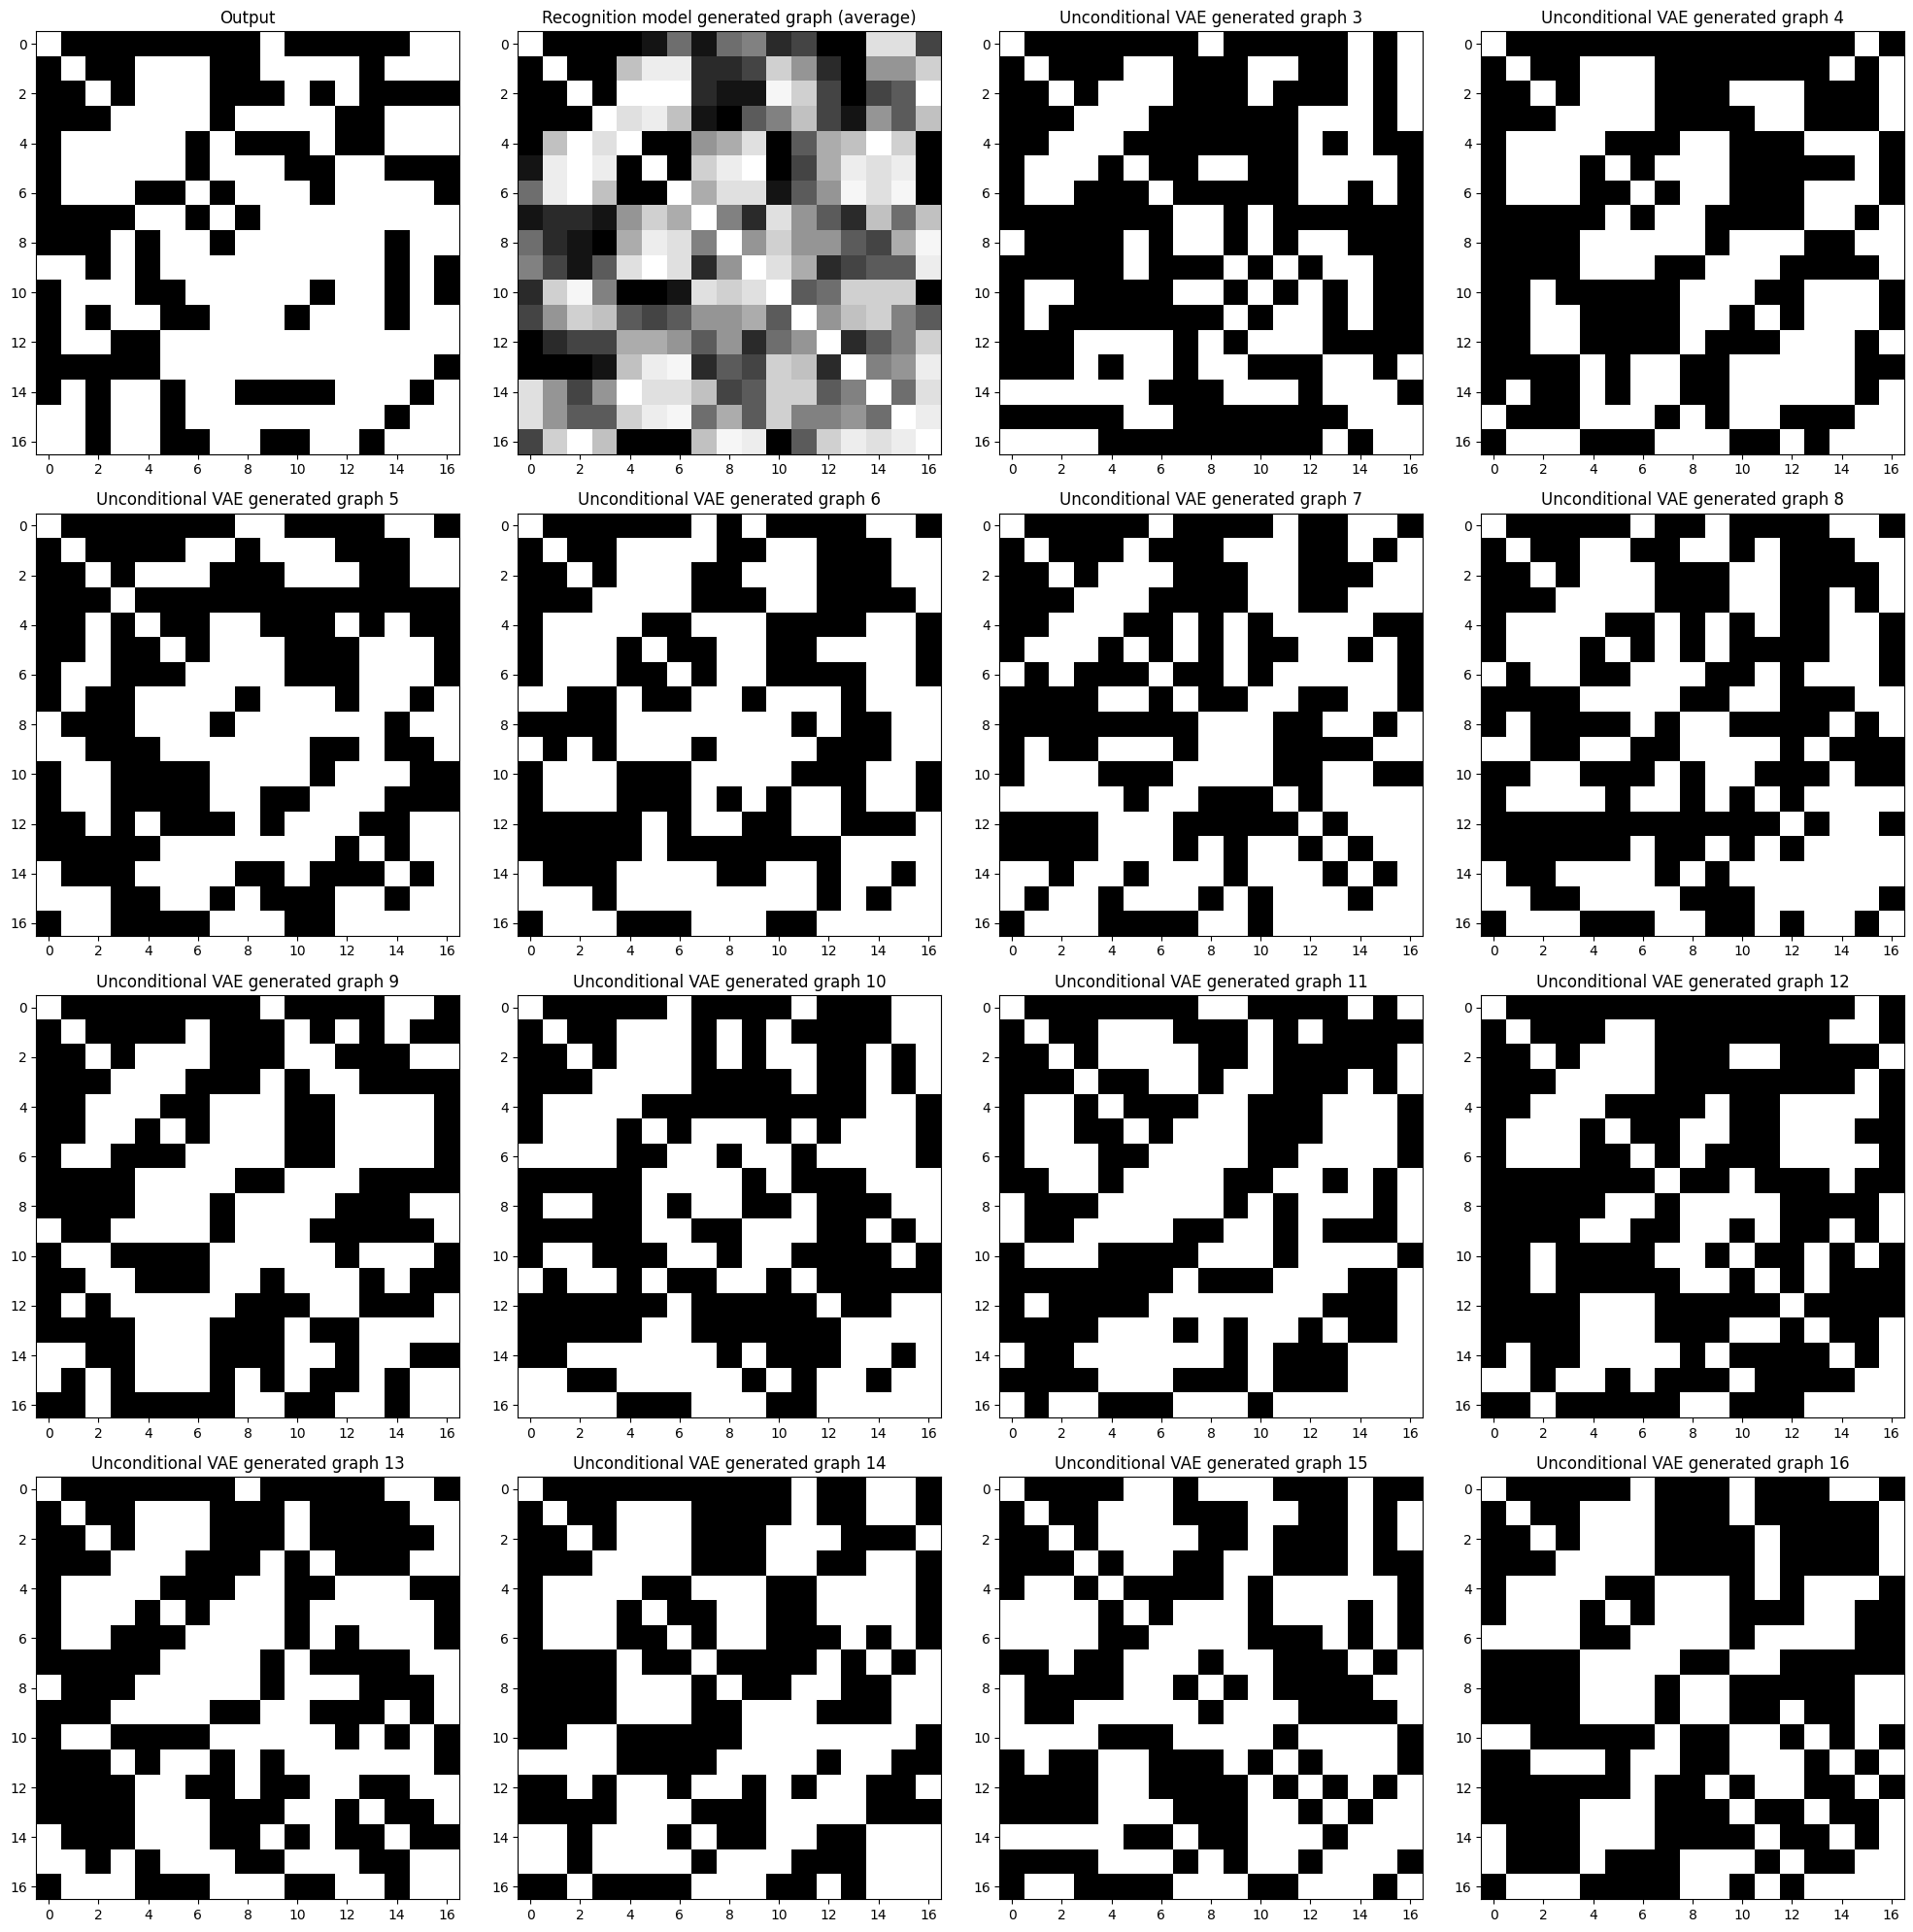

In [288]:

threshold = 0.5

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # Create a grid of 2 rows and 5 columns for the subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

ax = axes[0]
ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
# plt.colorbar()  # Add a colorbar to a plot
ax.set_title("Output")

avg_adj_mat_np = np.zeros((split, split))
for i in range(2, 16):
    adj_mat_np = vgae_model.generate().detach().numpy()[:split, :split]
    adj_mat_np[adj_mat_np < threshold] = 0
    adj_mat_np[adj_mat_np >= threshold] = 1
    # adj_mat_np = np.random.binomial(1, adj_mat_np)
    np.fill_diagonal(adj_mat_np, 0)
    avg_adj_mat_np += adj_mat_np
    ax = axes[i]  # Select the i-th subplot
    _ = ax.imshow(adj_mat_np, cmap='Greys', interpolation='nearest')  # Plot the matrix in the i-th subplot
    _ = ax.set_title(f"Unconditional VAE generated graph {i+1}")  # Set the title for the i-th subplot

avg_adj_mat_np /= 14
# avg_adj_mat_np[avg_adj_mat_np < 0.7] = 0
# avg_adj_mat_np[avg_adj_mat_np >= 0.7] = 1

ax = axes[1]
ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
ax.set_title("Recognition model generated graph (average)")


plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots

In [296]:
import imageio
import os
import copy

# Ensure the directory exists
os.makedirs('vgae', exist_ok=True)

threshold_values = np.linspace(0.5, 1, 10)  # Change this to the range of threshold values you want to use
filenames = []

adj_mat_np_list = []
# generate 14 graphs
for i in range(14):
    adj_mat_np_list.append(sigmoid(vgae_model.generate().detach().numpy())[:split, :split])

for t in threshold_values:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    axes = axes.flatten()

    ax = axes[0]
    _ = ax.imshow(adj_mat_out[:split, :split], cmap='Greys', interpolation='nearest')
    _ = ax.set_title("Output")

    avg_adj_mat_np = np.zeros((split, split))
    adj_mat_np_list_temp =copy.deepcopy(adj_mat_np_list)
    for adj_mat_np in adj_mat_np_list_temp:
        adj_mat_np[adj_mat_np < t] = 0
        adj_mat_np[adj_mat_np >= t] = 1
        np.fill_diagonal(adj_mat_np, 0)
        avg_adj_mat_np += adj_mat_np

    # avg_adj_mat_np[avg_adj_mat_np < threshold] = 0
    # avg_adj_mat_np[avg_adj_mat_np >= threshold] = 1
    # plot the average
    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')

    # plot the rest
    for i in range(2, 16):
        ax = axes[i]
        _ = ax.imshow(adj_mat_np_list_temp[i-2], cmap='Greys', interpolation='nearest')
        _ = ax.set_title(f"Recognition model generated graph {i}")

    avg_adj_mat_np /= 14
    ax = axes[1]
    _ = ax.imshow(avg_adj_mat_np, cmap='Greys', interpolation='nearest')
    _= ax.set_title("Recognition model generated graph (average)")

    plt.tight_layout()

    # Save the figure to a file
    filename = f'vgae/output_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)

    plt.close()  # Close the figure to free up memory

In [297]:
# from the images make a video
images = [imageio.imread(filename) for filename in filenames]
imageio.mimsave('vgae/output.gif', images, fps=1)

/var/folders/xs/_jggb8_n03q3bxbybznls2w1q5_5xx/T/ipykernel_71254/3859299581.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


# Experiment 

Let's random remove some edges from the input graph and see how well the models can recover the missing edges.

In [ ]:
graphs